Instantiate the MobileNet model

In [1]:
from keras.applications import MobileNet
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

17225924/17225924 [==============================] - 58s 3us/step


In [2]:
from keras.applications import MobileNet
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Architecture of the MobileNet convolutional base

In [3]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

Fast Feature Extraction without Data Augmentation

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(224, 224), batch_size=batch_size, class_mode='binary')
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch) 
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 293ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 256ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 249ms/step


The extracted features are currently of shape (samples, 7, 7, 1024). Feed them to a densely connected classifier, First flatten them (samples, 50176)

In [6]:
train_features = np.reshape(train_features, (2000, 7*7* 1024))
validation_features = np.reshape(validation_features, (1000, 7*7* 1024))
test_features = np.reshape(test_features, (1000, 7*7* 1024))

Define densely connected classifier (the use of dropout for regularization) and train it on the data and labels

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 1024))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

In [9]:
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 11s 105ms/step - loss: 0.1999 - acc: 0.9255 - val_loss: 0.0477 - val_acc: 0.9840
Epoch 2/30
100/100 [==============================] - 10s 101ms/step - loss: 0.0412 - acc: 0.9865 - val_loss: 0.0680 - val_acc: 0.9730
Epoch 3/30
100/100 [==============================] - 10s 102ms/step - loss: 0.0092 - acc: 0.9965 - val_loss: 0.0477 - val_acc: 0.9790
Epoch 4/30
100/100 [==============================] - 10s 101ms/step - loss: 0.0094 - acc: 0.9980 - val_loss: 0.0455 - val_acc: 0.9780
Epoch 5/30
100/100 [==============================] - 10s 101ms/step - loss: 0.0037 - acc: 0.9995 - val_loss: 0.0364 - val_acc: 0.9840
Epoch 6/30
100/100 [==============================] - 10s 102ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0375 - val_acc: 0.9850
Epoch 7/30
100/100 [==============================] - 10s 102ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0352 - val_acc: 0.9840
Epoch 8/30
100/100 [==============================] - 1

The loss and accuracy curves during training.

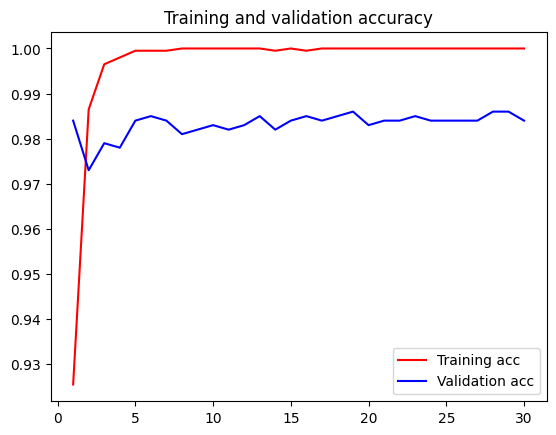

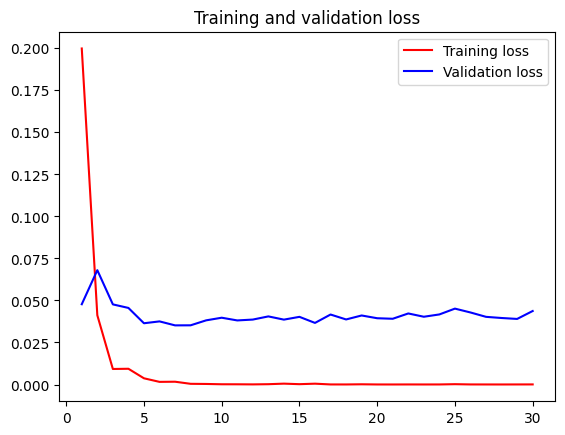

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Overfitted! need data augmentation, due to the small dataset.

Calculating Accuracy, Precision, Recall, and F1-score

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting on test data
test_predictions = model.predict(test_features)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=['Cat', 'Dog']))


32/32 [==============================] - 0s 9ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.98      0.98       500
         Dog       0.98      0.98      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



Generating the Confusion Matrix

Confusion Matrix:
[[492   8]
 [ 10 490]]


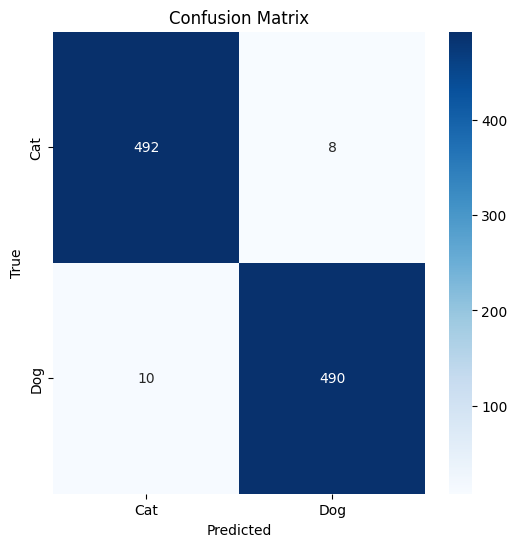

In [12]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Feature Extraction with Data Augmentation

In [1]:
from keras.applications import MobileNet
conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [2]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16074433 (61.32 MB)
Trainable params: 16052545 (61.24 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


Freeze the convolutional base

In [4]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 85
This is the number of trainable weights after freezing the conv base: 4


Start training model, with the data-augmentation configuration

In [6]:
import os
import numpy as np

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['acc'])

In [9]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 51s 498ms/step - loss: 0.2393 - acc: 0.9130 - val_loss: 0.1221 - val_acc: 0.9620
Epoch 2/30
100/100 [==============================] - 51s 511ms/step - loss: 0.1280 - acc: 0.9505 - val_loss: 0.0631 - val_acc: 0.9800
Epoch 3/30
100/100 [==============================] - 58s 577ms/step - loss: 0.0974 - acc: 0.9660 - val_loss: 0.0787 - val_acc: 0.9760
Epoch 4/30
100/100 [==============================] - 58s 580ms/step - loss: 0.1112 - acc: 0.9610 - val_loss: 0.0616 - val_acc: 0.9790
Epoch 5/30
100/100 [==============================] - 61s 608ms/step - loss: 0.0694 - acc: 0.9740 - val_loss: 0.0667 - val_acc: 0.9780
Epoch 6/30
100/100 [==============================] - 59s 594ms/step - loss: 0.0732 - acc: 0.9770 - val_loss: 0.0659 - val_acc: 0.9760
Epoch 7/30
100/100 [==============================] - 56s 555ms/step - loss: 0.0741 - acc: 0.9775 - val_loss: 0.0710 - val_acc: 0.9790
Epoch 8/30
100/100 [==============================] - 5

Plot the results

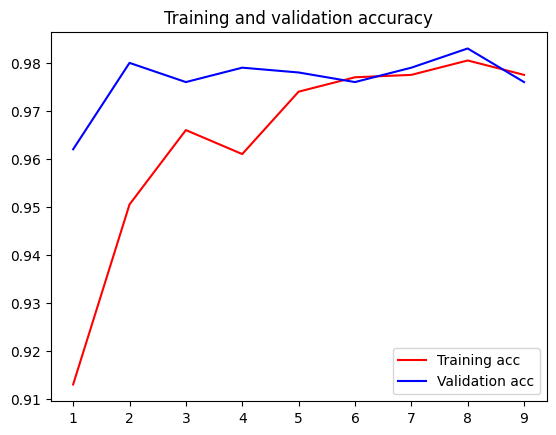

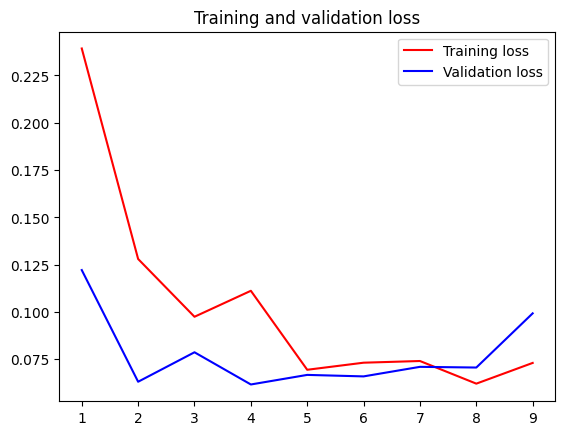

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Accuracy and loss much better than the previous model.

Calculating Accuracy, Precision, Recall, and F1-score

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 13s 262ms/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.98      0.98       500
         Dog       0.98      0.97      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



Generating the Confusion Matrix

Confusion Matrix:
[[491   9]
 [ 14 486]]


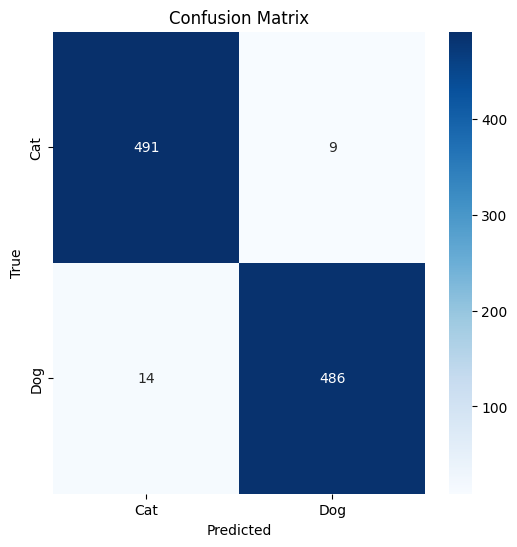

In [13]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning

In [1]:
from keras.applications import VGG19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22122049 (84.39 MB)
Trainable params: 22122049 (84.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fine-tune only the top two or three layers in the convolutional base

In [4]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Begin fine-tuning the network

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-5), metrics=['acc'])


In [8]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)


Epoch 1/30
100/100 [==============================] - 224s 2s/step - loss: 0.5791 - acc: 0.7070 - val_loss: 0.3923 - val_acc: 0.8130
Epoch 2/30
100/100 [==============================] - 233s 2s/step - loss: 0.3922 - acc: 0.8215 - val_loss: 0.2803 - val_acc: 0.8780
Epoch 3/30
100/100 [==============================] - 233s 2s/step - loss: 0.3414 - acc: 0.8430 - val_loss: 0.2579 - val_acc: 0.8980
Epoch 4/30
100/100 [==============================] - 232s 2s/step - loss: 0.2988 - acc: 0.8740 - val_loss: 0.2287 - val_acc: 0.9050
Epoch 5/30
100/100 [==============================] - 232s 2s/step - loss: 0.2814 - acc: 0.8830 - val_loss: 0.2138 - val_acc: 0.9080
Epoch 6/30
100/100 [==============================] - 234s 2s/step - loss: 0.2607 - acc: 0.8890 - val_loss: 0.2123 - val_acc: 0.9140
Epoch 7/30
100/100 [==============================] - 233s 2s/step - loss: 0.2385 - acc: 0.8980 - val_loss: 0.1954 - val_acc: 0.9050
Epoch 8/30
100/100 [==============================] - 233s 2s/step - 

Getting curves

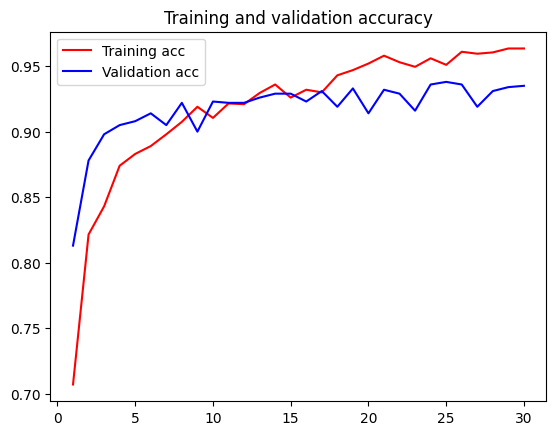

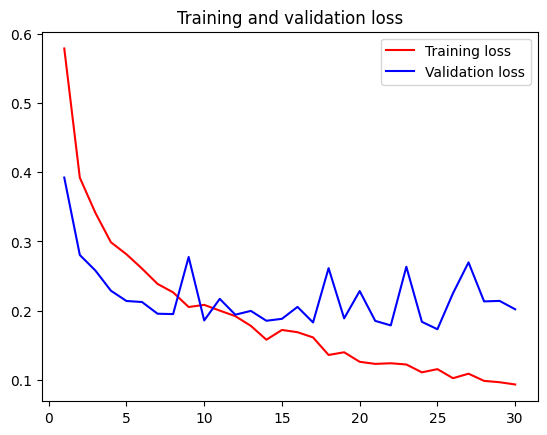

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Smoothing curves

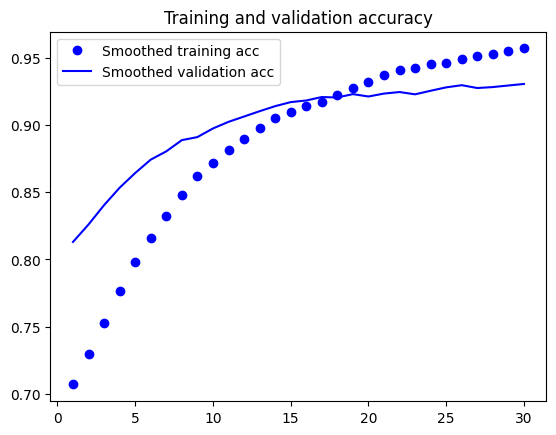

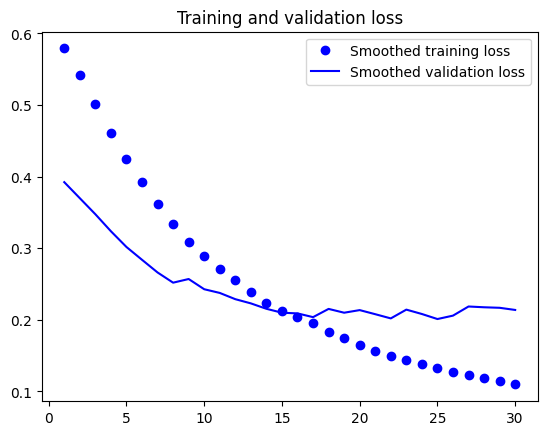

In [10]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

Above model shows overfitted performance.

Evaluate this model on the test data

In [11]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\laksi\AppData\Local\Temp\ipykernel_16548\452507608.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9359999895095825


Calculating Accuracy, Precision, Recall, and F1-score

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 51s 1s/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.91      0.93       500
         Dog       0.92      0.96      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



Generating the Confusion Matrix

Confusion Matrix:
[[456  44]
 [ 20 480]]


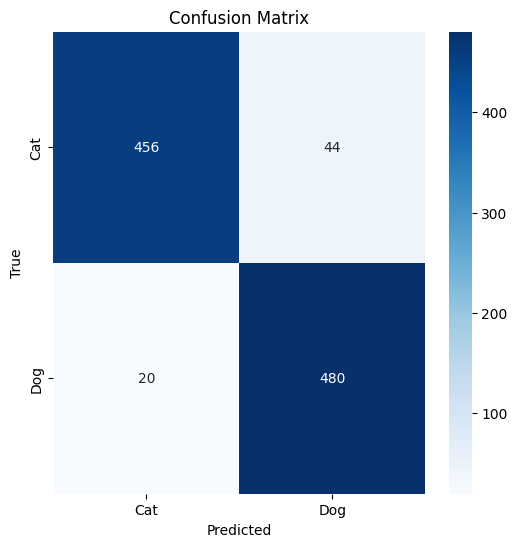

In [13]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning - 2

In [1]:
from keras.applications import VGG19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22122049 (84.39 MB)
Trainable params: 22122049 (84.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-5), metrics=['acc'])


In [8]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)


Epoch 1/30
100/100 [==============================] - 226s 2s/step - loss: 0.5769 - acc: 0.7110 - val_loss: 0.3991 - val_acc: 0.8220
Epoch 2/30
100/100 [==============================] - 236s 2s/step - loss: 0.3854 - acc: 0.8285 - val_loss: 0.2597 - val_acc: 0.8800
Epoch 3/30
100/100 [==============================] - 239s 2s/step - loss: 0.3103 - acc: 0.8595 - val_loss: 0.2446 - val_acc: 0.9000
Epoch 4/30
100/100 [==============================] - 239s 2s/step - loss: 0.2642 - acc: 0.8900 - val_loss: 0.2153 - val_acc: 0.9030
Epoch 5/30
100/100 [==============================] - 237s 2s/step - loss: 0.2449 - acc: 0.8930 - val_loss: 0.2062 - val_acc: 0.9150
Epoch 6/30
100/100 [==============================] - 236s 2s/step - loss: 0.2367 - acc: 0.9040 - val_loss: 0.2363 - val_acc: 0.9120
Epoch 7/30
100/100 [==============================] - 236s 2s/step - loss: 0.1978 - acc: 0.9190 - val_loss: 0.1876 - val_acc: 0.9200
Epoch 8/30
100/100 [==============================] - 236s 2s/step - 

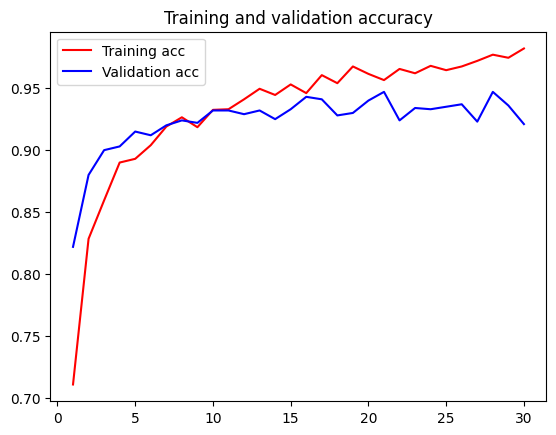

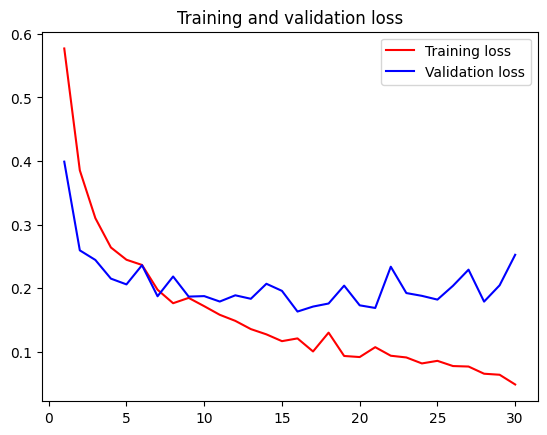

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

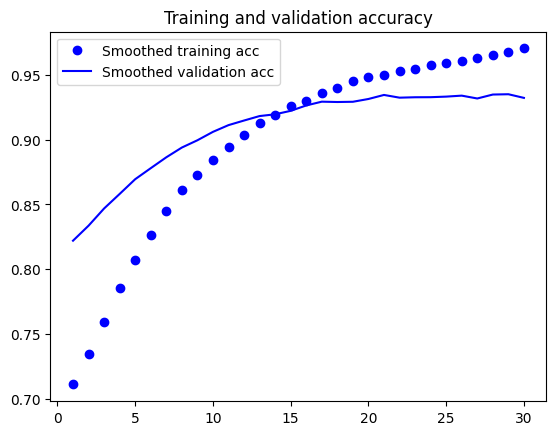

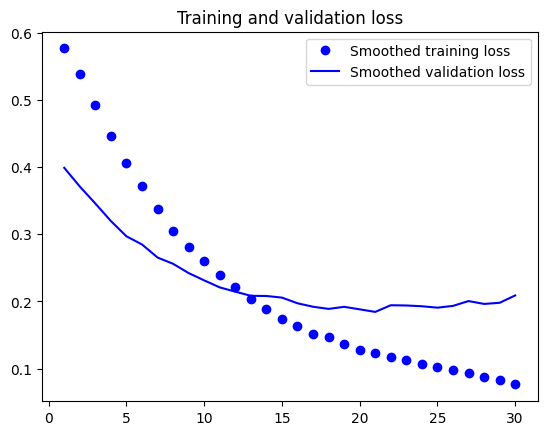

In [10]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

In [11]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\laksi\AppData\Local\Temp\ipykernel_4196\452507608.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9269999861717224


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 54s 1s/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.88      0.92       500
         Dog       0.89      0.98      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



Confusion Matrix:
[[438  62]
 [ 11 489]]


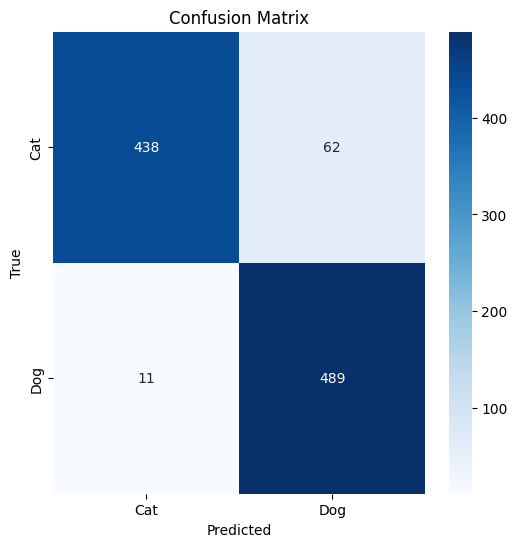

In [13]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fine Tuning - 3

In [16]:
from keras.applications import VGG19
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [17]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [18]:
from keras import models, layers, optimizers, regularizers

# Model definition
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22122049 (84.39 MB)
Trainable params: 22122049 (84.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Unfreezing only the last few layers of the VGG19 model
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [21]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/laksi/Desktop/4th Year - Notebooks/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [22]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
# Compile the model with Adam optimizer and reduced learning rate
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['acc'])

In [25]:
from keras.callbacks import EarlyStopping

# Implementing early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 199s 2s/step - loss: 1.1488 - acc: 0.6090 - val_loss: 1.0063 - val_acc: 0.7430
Epoch 2/30
100/100 [==============================] - 208s 2s/step - loss: 1.0382 - acc: 0.7035 - val_loss: 0.8819 - val_acc: 0.8310
Epoch 3/30
100/100 [==============================] - 210s 2s/step - loss: 0.9528 - acc: 0.7525 - val_loss: 0.8070 - val_acc: 0.8470
Epoch 4/30
100/100 [==============================] - 216s 2s/step - loss: 0.8732 - acc: 0.7955 - val_loss: 0.7578 - val_acc: 0.8690
Epoch 5/30
100/100 [==============================] - 214s 2s/step - loss: 0.8287 - acc: 0.8315 - val_loss: 0.7233 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 211s 2s/step - loss: 0.7970 - acc: 0.8420 - val_loss: 0.6934 - val_acc: 0.8800
Epoch 7/30
100/100 [==============================] - 223s 2s/step - loss: 0.7697 - acc: 0.8535 - val_loss: 0.7067 - val_acc: 0.8830
Epoch 8/30
100/100 [==============================] - 214s 2s/step - 

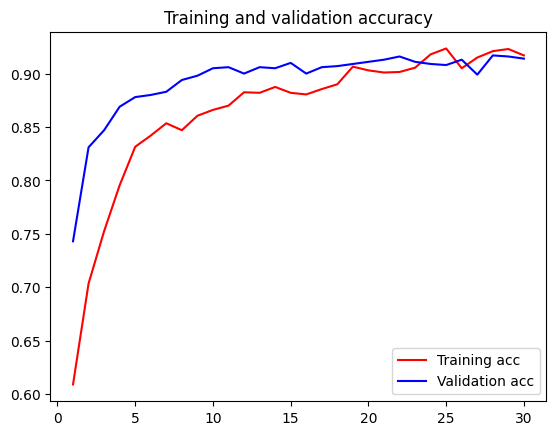

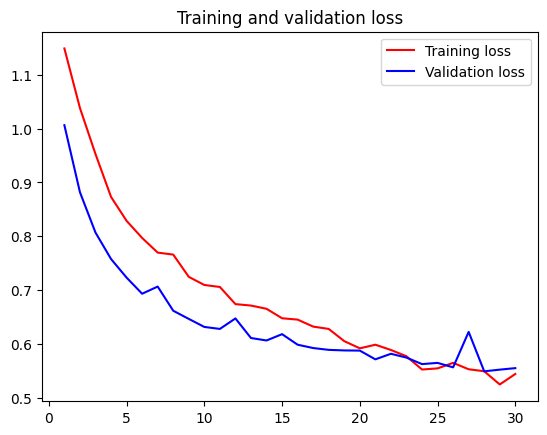

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

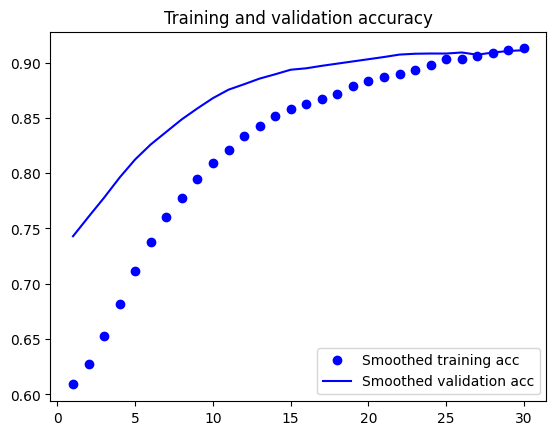

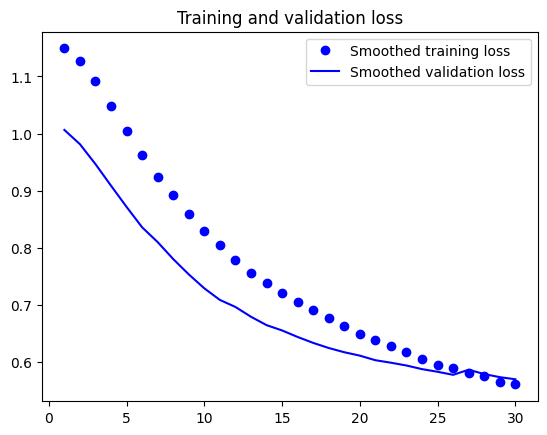

In [28]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting smoothed training and validation accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Plotting smoothed training and validation loss
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

# Display the plots
plt.show()

In [29]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\laksi\AppData\Local\Temp\ipykernel_4196\452507608.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9039999842643738


In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)  # Important: shuffle=False to match predictions with labels

# Predicting on test data
test_steps = test_generator.samples // test_generator.batch_size
test_predictions = model.predict(test_generator, steps=test_steps)
test_predictions = (test_predictions > 0.5).astype(int).reshape(-1)  # Convert probabilities to binary (0 or 1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions, target_names=['Cat', 'Dog']))


Found 1000 images belonging to 2 classes.
50/50 [==============================] - 53s 1s/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.95      0.85      0.90       500
         Dog       0.86      0.96      0.91       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



Confusion Matrix:
[[425  75]
 [ 21 479]]


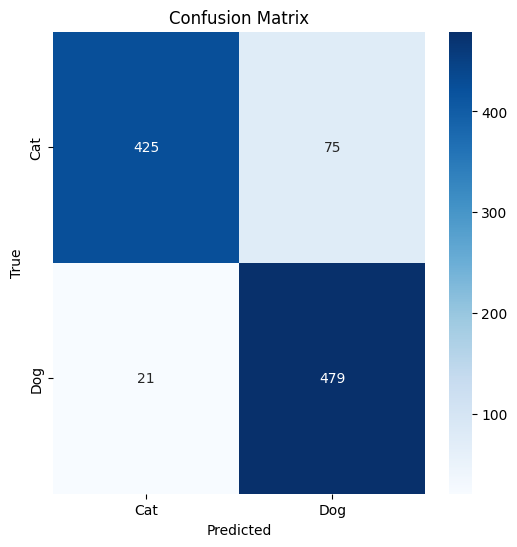

In [31]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


5 models from VGG19 completed.